In [1]:
# Código para que los resultados no se corten
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [2]:
# conditional install
try:
  from pytorch_tabnet.tab_model import TabNetClassifier
except ModuleNotFoundError:
  if 'google.colab' in str(get_ipython()):
    %pip install pytorch-tabnet

  from pytorch_tabnet.tab_model import TabNetClassifier

<IPython.core.display.Javascript object>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 400.3 kB/s eta 0:00:00


In [3]:
import random
import os
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score, balanced_accuracy_score, roc_auc_score, matthews_corrcoef, f1_score
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.augmentations import ClassificationSMOTE
import seaborn as sns

<IPython.core.display.Javascript object>

In [4]:
# Función para definir en un solo lugar todas las semillas
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(42)

<IPython.core.display.Javascript object>

Leemos el archivo y seleccionamos las features

In [5]:
df = pd.read_csv('postprandial_hypoglycemias.csv')

selected_features = ['glucose','glucose_range','glucose_rate_change','glucose_rate_change','mean_glucose_1h','glucose_1h','glucose_30m','cho', 'basal', 'bolus_normal', 'total_bolus_squared',
                'cob','next_iob','iob','aob_3h','aob_6h','hour']

target = 'hypoglycemia_multiclass'
df = df[selected_features + [target]]
df = df.dropna()
df = df.reset_index(drop=True)


<IPython.core.display.Javascript object>

Separamos los datos en grupos de entrenamiento, validación y test, procurando que todas tengan el mismo porcentaje de datos con hipoglicemia con stratify

In [6]:
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)


<IPython.core.display.Javascript object>

In [7]:
print(f'Total de registros: {len(df)}')
print(f'Total de registros con hipoglicemia: {np.count_nonzero(y == 1)}')
print(f'Total de registros con hipoglicemia severa: {np.count_nonzero(y == 2)}')
print(f'Total de registros datos de entrenamiento: {len(y_train)}')
print(f'Total de registros datos de entrenamiento con hipoglicemia: {np.count_nonzero(y_train == 1)}')
print(f'Total de registros datos de entrenamiento con hipoglicemia severa: {np.count_nonzero(y_train == 2)}')
print(f'Total de registros datos de test: {len(y_test)}')
print(f'Total de registros datos de test con hipoglicemia: {np.count_nonzero(y_test == 1)}')
print(f'Total de registros datos de test con hipoglicemia severa: {np.count_nonzero(y_test == 2)}')

<IPython.core.display.Javascript object>

Total de registros: 654
Total de registros con hipoglicemia: 77
Total de registros con hipoglicemia severa: 27
Total de registros datos de entrenamiento: 457
Total de registros datos de entrenamiento con hipoglicemia: 54
Total de registros datos de entrenamiento con hipoglicemia severa: 19
Total de registros datos de test: 197
Total de registros datos de test con hipoglicemia: 23
Total de registros datos de test con hipoglicemia severa: 8


Calculamos los pesos de cada clase para pasar como parámetro al modelo

In [8]:
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
print(class_weights_dict)

<IPython.core.display.Javascript object>

{0: 0.3967013888888889, 1: 2.8209876543209877, 2: 8.017543859649123}


In [9]:
# Implementación de la métrica para F1 score
class F1Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)

        return f1_score(y_true, y_pred)

<IPython.core.display.Javascript object>

In [10]:
# Implementación de la métrica para MCC
class MCC(Metric):
    def __init__(self):
        self._name = "MCC"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        mcc_numerator = (tp * tn) - (fp * fn)
        mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        if mcc_denominator == 0:
            return 0
        else:
            return mcc_numerator / mcc_denominator

<IPython.core.display.Javascript object>

Entrenamiento del modelo en TabNet

In [11]:
n_steps = 5
gamma = 1.3
patience = 50
epochs = 150
aug = ClassificationSMOTE(p=0.3)
batch_size = 64
virtual_batch_size = 8
evaluation_metrics = ['balanced_accuracy']

classifier = TabNetClassifier(
                              verbose=1,
                              n_steps=n_steps,
                              gamma=gamma
                              )

classifier.fit(
               X_train=X_train.values, y_train=y_train,
               eval_set=[(X_train.values, y_train)],
               eval_name=['train'],
               batch_size=batch_size,
               virtual_batch_size=virtual_batch_size,
               patience=patience,
               max_epochs=epochs,
               weights=class_weights_dict,
               eval_metric= evaluation_metrics,
               augmentations=aug
               )



<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.39679 | train_balanced_accuracy: 0.37622 |  0:00:03s
epoch 1  | loss: 1.63186 | train_balanced_accuracy: 0.33485 |  0:00:04s
epoch 2  | loss: 1.18919 | train_balanced_accuracy: 0.35548 |  0:00:06s
epoch 3  | loss: 1.10274 | train_balanced_accuracy: 0.38169 |  0:00:07s
epoch 4  | loss: 1.08407 | train_balanced_accuracy: 0.33393 |  0:00:09s
epoch 5  | loss: 1.10724 | train_balanced_accuracy: 0.35481 |  0:00:10s
epoch 6  | loss: 1.08566 | train_balanced_accuracy: 0.34711 |  0:00:11s
epoch 7  | loss: 1.09207 | train_balanced_accuracy: 0.32302 |  0:00:12s
epoch 8  | loss: 1.04689 | train_balanced_accuracy: 0.36148 |  0:00:13s
epoch 9  | loss: 1.0488  | train_balanced_accuracy: 0.42087 |  0:00:14s
epoch 10 | loss: 1.04993 | train_balanced_accuracy: 0.43354 |  0:00:16s
epoch 11 | loss: 1.03685 | train_balanced_accuracy: 0.4113  |  0:00:17s
epoch 12 | loss: 1.03524 | train_balanced_accuracy: 0.44793 |  0:00:19s
epoch 13 | loss: 1.02357 | train_balanced_accuracy: 0.43586 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Métricas durante el entrenamiento

<IPython.core.display.Javascript object>

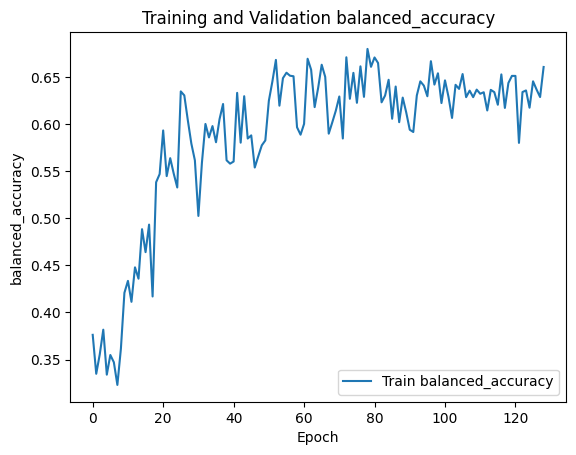

In [12]:
for metric in evaluation_metrics:
    plt.figure()
    plt.plot(classifier.history['train_' + metric], label='Train ' + metric)
    plt.title('Training and Validation ' + metric)
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Obtenemos las predicciones y las probabilidades

In [13]:
y_pred_probs = classifier.predict_proba(X_test.values)
y_pred = np.argmax(y_pred_probs, axis=1)

<IPython.core.display.Javascript object>

**Matriz de confusión**

<IPython.core.display.Javascript object>

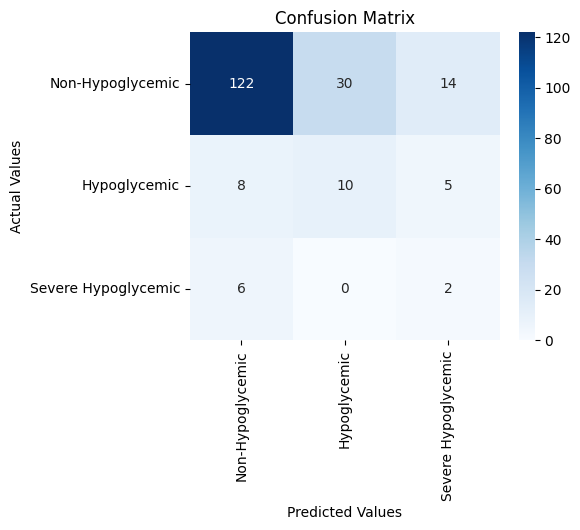

In [15]:
cm = confusion_matrix(y_test, y_pred)


cm_df = pd.DataFrame(cm,
                     index = ['Non-Hypoglycemic', 'Hypoglycemic','Severe Hypoglycemic'],
                     columns = ['Non-Hypoglycemic', 'Hypoglycemic','Severe Hypoglycemic'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

**Matriz de confusión**

<IPython.core.display.Javascript object>

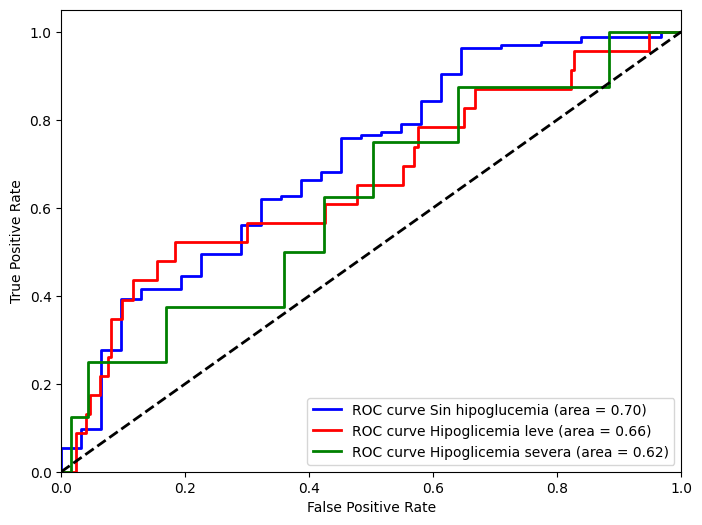

In [16]:
n_classes = y_pred_probs.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
clases = ['Sin hipoglucemia','Hipoglicemia leve','Hipoglicemia severa']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve {0} (area = {1:0.2f})'
             ''.format(clases[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right")
plt.show()

**Resumen métricas modelo TabNet**

In [17]:
cm = confusion_matrix(y_test, y_pred)

sensitivity = dict()
specificity = dict()
for i in range(cm.shape[0]):
    tp = cm[i, i]
    fn = sum(cm[i, :]) - tp
    fp = sum(cm[:, i]) - tp
    tn = cm.sum() - (tp + fp + fn)
    sensitivity[i] = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity[i] = tn / (tn + fp) if (tn + fp) != 0 else 0

report = classification_report(y_test, y_pred, target_names=['Non-Hypoglycemic', 'Hypoglycemic','Severe Hypoglycemic'], output_dict=True)
f1Score = {class_name: report[class_name]['f1-score'] for class_name in report if class_name in ['Non-Hypoglycemic', 'Hypoglycemic','Severe Hypoglycemic']}
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
from sklearn.metrics import f1_score
newf1 = f1_score(y_test, y_pred, average=None)

metrics = {
    'MCC': mcc,
    'F1 Score': f1Score,
    'Balanced Accuracy': balanced_accuracy,
    'Accuracy': accuracy,
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'Classification Report': report
}
print(newf1)
metrics


<IPython.core.display.Javascript object>

[0.80794702 0.31746032 0.13793103]


{'MCC': 0.19589658475378674,
 'F1 Score': {'Non-Hypoglycemic': 0.8079470198675497,
  'Hypoglycemic': 0.3174603174603175,
  'Severe Hypoglycemic': 0.13793103448275862},
 'Balanced Accuracy': 0.47324078924393226,
 'Accuracy': 0.6802030456852792,
 'Sensitivity': {0: 0.7349397590361446, 1: 0.43478260869565216, 2: 0.25},
 'Specificity': {0: 0.5483870967741935,
  1: 0.8275862068965517,
  2: 0.8994708994708994},
 'Classification Report': {'Non-Hypoglycemic': {'precision': 0.8970588235294118,
   'recall': 0.7349397590361446,
   'f1-score': 0.8079470198675497,
   'support': 166},
  'Hypoglycemic': {'precision': 0.25,
   'recall': 0.43478260869565216,
   'f1-score': 0.3174603174603175,
   'support': 23},
  'Severe Hypoglycemic': {'precision': 0.09523809523809523,
   'recall': 0.25,
   'f1-score': 0.13793103448275862,
   'support': 8},
  'accuracy': 0.6802030456852792,
  'macro avg': {'precision': 0.41409897292250236,
   'recall': 0.47324078924393226,
   'f1-score': 0.42111279060354195,
   'suppo

**Mostramos las features ordenadas por importancia del modelo**

In [18]:
feature_importances = classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.to_string(index=False))

<IPython.core.display.Javascript object>

            Feature  Importance
            glucose    0.326264
                cob    0.237405
             aob_6h    0.108922
glucose_rate_change    0.092149
              basal    0.055534
      glucose_range    0.052795
       bolus_normal    0.048421
             aob_3h    0.040415
         glucose_1h    0.015197
glucose_rate_change    0.013217
    mean_glucose_1h    0.009305
        glucose_30m    0.000376
                cho    0.000000
total_bolus_squared    0.000000
           next_iob    0.000000
                iob    0.000000
               hour    0.000000


**Gráfica interpretabilidad general del modelo**

<IPython.core.display.Javascript object>

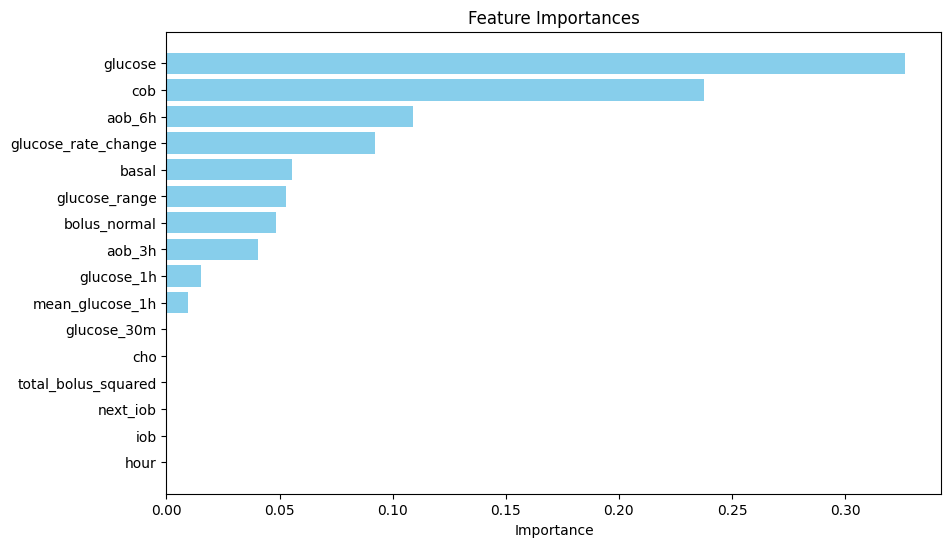

In [19]:
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

**Interpretabilidad del grupo test por instancia y máscara**

<IPython.core.display.Javascript object>

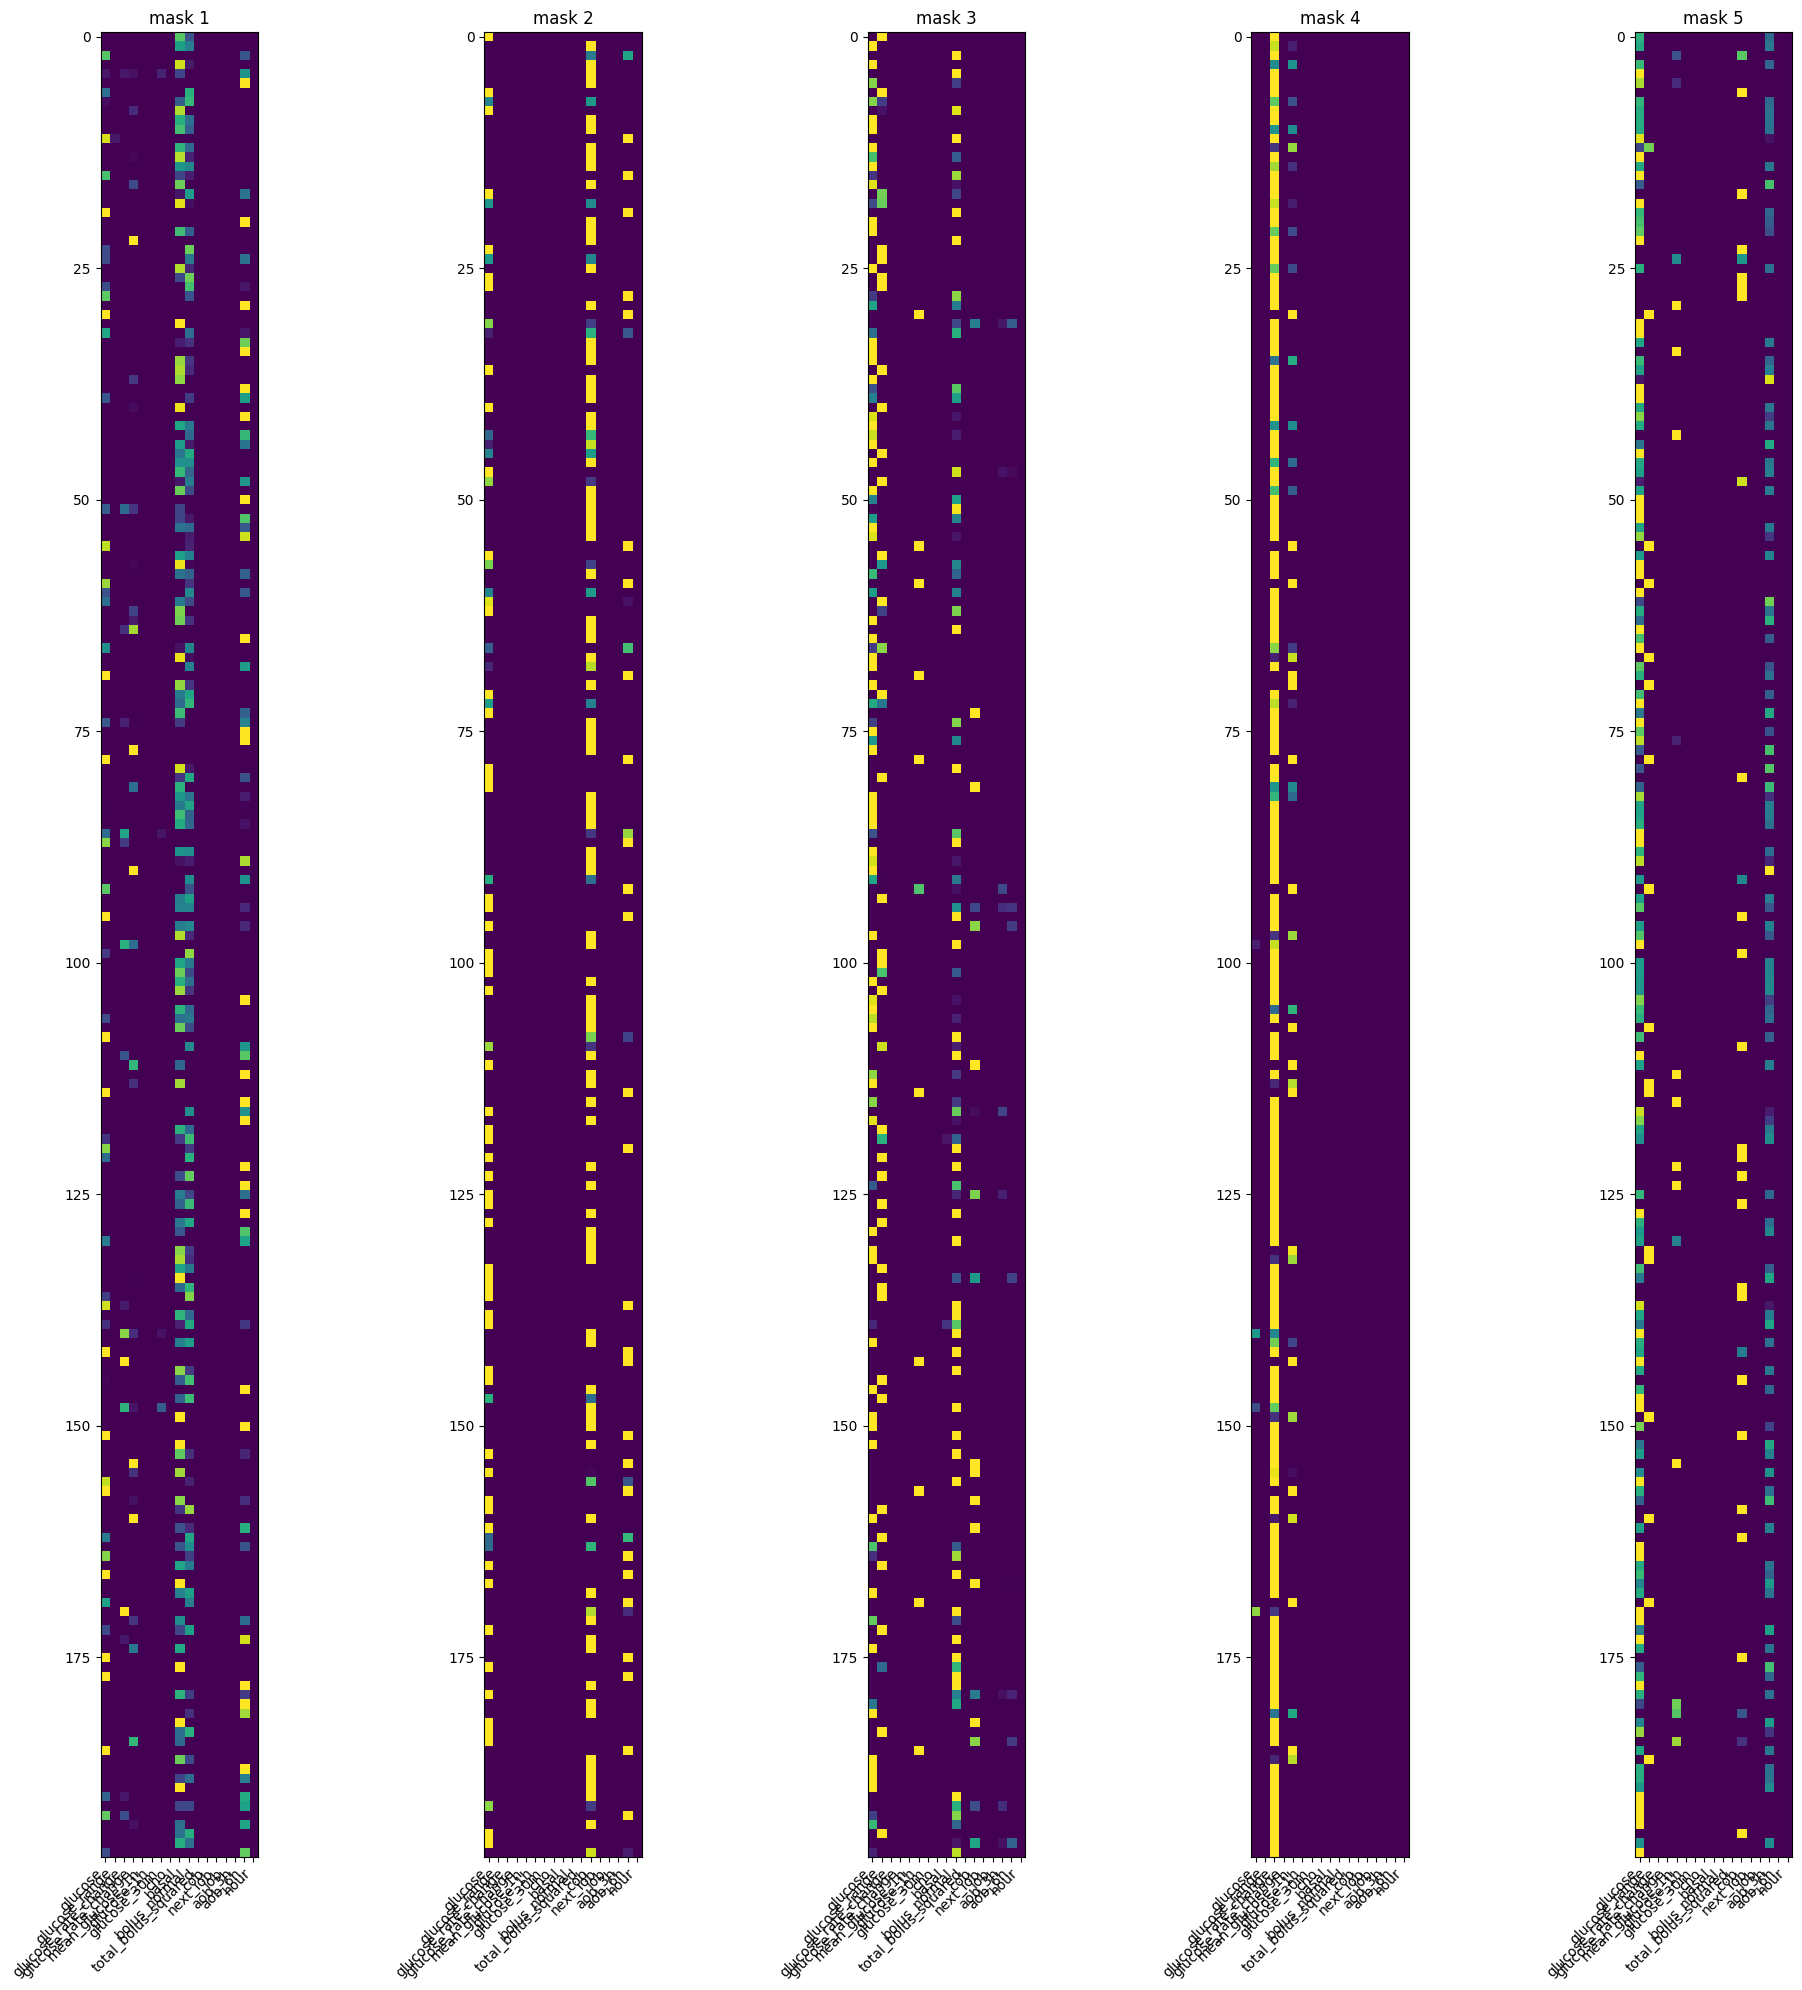

In [24]:
explain_matrix, masks = classifier.explain(X_test.values)
n_steps = len(masks)
fig, axs = plt.subplots(1, n_steps, figsize=(20, 20))

for i in range(n_steps):
    axs[i].imshow(masks[i][:len(X_test.values)])
    axs[i].set_title(f"mask {i + 1}")
    axs[i].set_xticks(range(len(selected_features)))
    axs[i].set_xticklabels(labels=selected_features, rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Interpretabilidad del grupo test agregada**

<IPython.core.display.Javascript object>

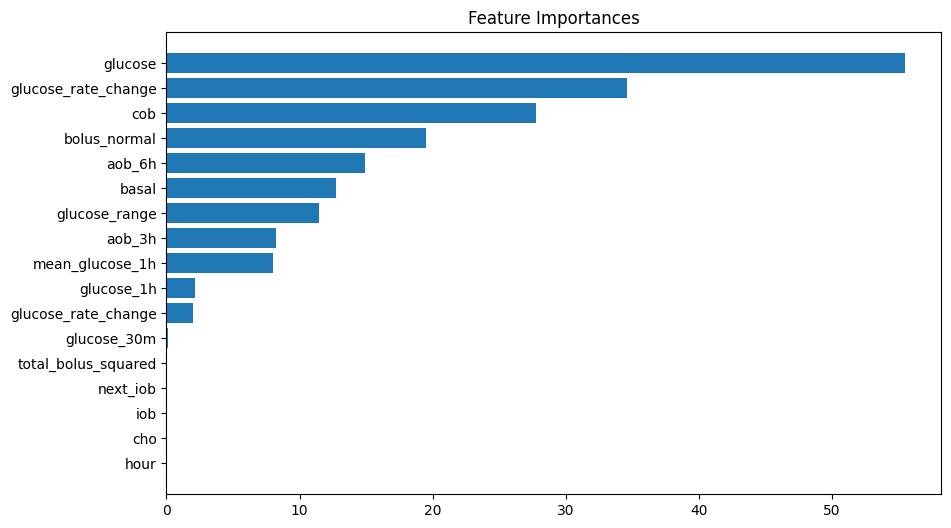

In [21]:
sum_of_features = None

# Sumar las importancias de las características de todas las máscaras
for mask in masks.values():
    if sum_of_features is None:
        sum_of_features = np.sum(mask, axis=0)
    else:
        sum_of_features += np.sum(mask, axis=0)

# Calcular el promedio dividiendo por el número total de máscaras
average_features = sum_of_features / len(masks)

# Ordenar las características y sus importancias promedio de mayor a menor
sorted_indices = np.argsort(average_features)[::-1]
sorted_features = np.array(selected_features)[sorted_indices]
sorted_importances = average_features[sorted_indices]

# Visualización con barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances)
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invertir el eje Y para que la característica más importante esté arriba
plt.show()